In [3]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List, Tuple


In [4]:
# Load the JSON data
with open('../100_article_analysis/Combined_QnA_eng_India_election_2024.json', 'r') as file_eng:
    articles_eng = json.load(file_eng)

with open('../100_article_analysis/Combined_QnA_hin_India_election_2024.json', 'r') as file_hin:
    articles_hin = json.load(file_hin)


In [5]:
# Save the embeddings as a TSV file
def save_tsv(embeddings, filename):
    np.savetxt(filename, embeddings, delimiter='\t')

# Create a metadata TSV file
def save_metadata(metadata, filename):
    with open(filename, 'w') as f:
        for item in metadata:
            f.write(f"{item}\n")

In [7]:
def prepare_data(articles):
    # Extract questions and answers
    M = len(articles)
    questions = articles[0]['QnA']
    N = len(questions)

    # Create answer matrix
    answer_matrix = np.zeros((M, N), dtype=int)
    Kn = [0] * N  # Initialize number of categories per question

    for i, article in enumerate(articles):
        for j, qna in enumerate(article['QnA']):
            answer_matrix[i, j] = ord(qna['post_LLM_answer']) - ord('A')+1 # Convert answers to integers
            Kn[j] = max(Kn[j], answer_matrix[i, j])  # Update the number of categories for each question

    return M, N, answer_matrix, Kn

In [8]:
class FactorModel(nn.Module):
    def __init__(self, N: int, Kn: List[int], d: int):
        super(FactorModel, self).__init__()
        self.N = N  # Number of questions
        self.Kn = Kn  # List of number of categorical answers for each question
        self.d = d  # Latent dimension
        self.W = nn.ModuleList([nn.Linear(d, Kn[i] - 1, bias=False) for i in range(N)])
        self.biases = nn.ParameterList([nn.Parameter(torch.randn(Kn[i] - 1)) for i in range(N)])

    def forward(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = [self.W[n](v) + self.biases[n] for n in range(self.N)]
        # Append zero logits for the last category to each question's logits
        logits = [torch.cat((logit, torch.zeros(logit.size(0), 1).to(logit.device)), dim=1) for logit in logits]
        return logits

    def predict_proba(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = self.forward(v)  # List of logits for each question
        probabilities = [torch.softmax(logit, dim=-1) for logit in logits]
        return probabilities

In [9]:
def loss_function(
    model: FactorModel,
    v: torch.Tensor,
    answers: torch.Tensor,
    lambda1: float,
    lambda2: float,
) -> torch.Tensor:

    criterion = nn.NLLLoss(reduction="sum")
    logits = model.forward(v)

    total_loss = 0
    for n in range(model.N):
        log_probs = nn.functional.log_softmax(logits[n], dim=1)
        total_loss += criterion(log_probs, answers[:, n] - 1)  # Adjusting answers to be zero-based index
    nll_loss = total_loss.clone()

    # L2 Regularization
    l2_reg = sum(torch.norm(W.weight, 2) ** 2 for W in model.W)
    total_loss += lambda1 * l2_reg
    total_loss += lambda2 * torch.norm(v, 2) ** 2
    return total_loss, nll_loss




In [10]:
def train_model(
    model: FactorModel,
    answers: torch.Tensor,
    epochs: int = 1000,
    lr: float = 0.01,
    lambda1: float = 0.01,
    lambda2: float = 0.01,
) -> Tuple[FactorModel, torch.Tensor]:
    # Initialize v as a learnable parameter
    v = torch.randn(len(answers), model.d, requires_grad=True)
    # Add v to the list of parameters for the optimizer
    optimizer = optim.Adam(list(model.parameters()) + [v], lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, nllloss = loss_function(model, v, answers, lambda1, lambda2)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, NLL Loss: {nllloss.item()}")

    return model, v.detach()

In [11]:
M1, N1, answer_matrix1, Kn1 = prepare_data(articles_eng)
Kn1 = [5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4]
model1 = FactorModel(N1, Kn1, 20)
model1, embeddings1 = train_model(model1, torch.tensor(answer_matrix1), epochs=1000, lr=0.01, lambda1=0.01, lambda2=0.01)

Epoch 0, Loss: 3406.6103515625, NLL Loss: 3386.60205078125
Epoch 100, Loss: 423.9906921386719, NLL Loss: 392.6650390625
Epoch 200, Loss: 103.48587036132812, NLL Loss: 61.5463981628418
Epoch 300, Loss: 68.81773376464844, NLL Loss: 23.08963966369629
Epoch 400, Loss: 60.16854476928711, NLL Loss: 13.82223129272461
Epoch 500, Loss: 55.94818878173828, NLL Loss: 10.30843448638916
Epoch 600, Loss: 53.047550201416016, NLL Loss: 8.673515319824219
Epoch 700, Loss: 50.755123138427734, NLL Loss: 7.8217902183532715
Epoch 800, Loss: 48.85485076904297, NLL Loss: 7.337594032287598
Epoch 900, Loss: 47.25849151611328, NLL Loss: 7.037182331085205


In [12]:
print(embeddings1.shape)

torch.Size([100, 20])


In [13]:
M2, N2, answer_matrix2, Kn2 = prepare_data(articles_eng)
Kn2= [5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4]
model2 = FactorModel(N2, Kn2, 20)
model2, embeddings2 = train_model(model2, torch.tensor(answer_matrix2), epochs=1000, lr=0.01, lambda1=0.01, lambda2=0.01)

Epoch 0, Loss: 3685.08447265625, NLL Loss: 3662.865966796875
Epoch 100, Loss: 458.9270324707031, NLL Loss: 425.87115478515625
Epoch 200, Loss: 108.89351654052734, NLL Loss: 65.7608642578125
Epoch 300, Loss: 71.40727996826172, NLL Loss: 24.490169525146484
Epoch 400, Loss: 62.086082458496094, NLL Loss: 14.473974227905273
Epoch 500, Loss: 57.606712341308594, NLL Loss: 10.630037307739258
Epoch 600, Loss: 54.5675163269043, NLL Loss: 8.824779510498047
Epoch 700, Loss: 52.16828536987305, NLL Loss: 7.878964900970459
Epoch 800, Loss: 50.168067932128906, NLL Loss: 7.344188213348389
Epoch 900, Loss: 48.474674224853516, NLL Loss: 7.0195488929748535


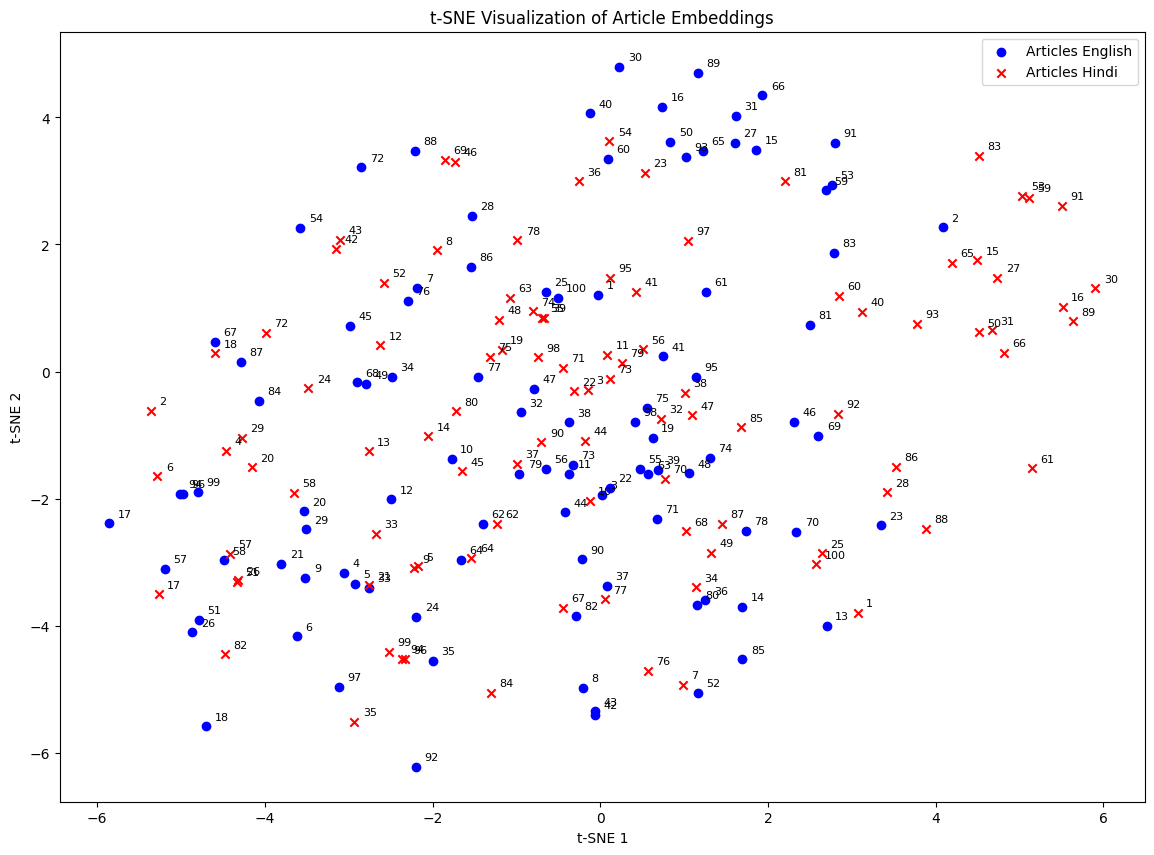

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Use t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d_1 = tsne.fit_transform(embeddings1.numpy())
embeddings_2d_2 = tsne.fit_transform(embeddings2.numpy())

# Increase the plot size
plt.figure(figsize=(14, 10))

# Plot the embeddings
plt.scatter(embeddings_2d_1[:, 0], embeddings_2d_1[:, 1], c='blue', marker='o', label='Articles English')
plt.scatter(embeddings_2d_2[:, 0], embeddings_2d_2[:, 1], c='red', marker='x', label='Articles Hindi')

# Add labels for clarity, slightly offset to prevent overlap with points
for i in range(len(embeddings_2d_1)):
    plt.annotate(str(i+1), (embeddings_2d_1[i, 0] + 0.1, embeddings_2d_1[i, 1] + 0.1), fontsize=8)
for i in range(len(embeddings_2d_2)):
    plt.annotate(str(i+1), (embeddings_2d_2[i, 0] + 0.1, embeddings_2d_2[i, 1] + 0.1), fontsize=8)

plt.title('t-SNE Visualization of Article Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()
plt.show()




In [15]:
# Indices of isolated points
isolated_eng_indices = [30,89,16,91,27,15,31,66,50,93,40,60]
isolated_hin_indices = [35,97,17,51,57,26,21,5,9,33,24,18,92]

# Retrieve corresponding articles
isolated_eng_articles = [articles_eng[i] for i in isolated_eng_indices]  # Subtract 1 for zero-based index
isolated_hin_articles = [articles_hin[i] for i in isolated_hin_indices]  # Subtract 1 for zero-based index

# Print summaries
print("English Articles Summary:")
for body in isolated_eng_articles:
    print(body['body'])

print("\nHindi Articles Summary:")
for body in isolated_hin_articles:
    print(body['body'])

English Articles Summary:
Get latest articles and stories on India at LatestLY. The world experienced the warmest May ever, with record heat, rain and floods wreaking havoc in many countries, according to new data released on Wednesday.

New Delhi, Jun 5 (PTI) The world experienced the warmest May ever, with record heat, rain and floods wreaking havoc in many countries, according to new data released on Wednesday.

It was also the 12 consecutive month of record-high temperatures, a result of the combined effect of now weakening El Nino and human-caused climate change, the European Union's climate agency Copernicus Climate Change Service (C3S) said.

Also Read | AP EAMCET Results 2024: Examination Results of EAPCET To Be Announced Soon at cets.apsche.ap.gov.in, Know Steps To Check Rank Cards.

The update from Copernicus coincided with the World Meteorological Organization (WMO) prediction that there is an 80 per cent chance that one of the next five years will be at least 1.5 degrees Ce

In [206]:
#find l2 distance between embeddings
from scipy.spatial.distance import cdist

# Calculate the pairwise L2 distance between the embeddings
distances = cdist(embeddings1, embeddings2, metric='euclidean')

# Find the indices of the minimum distances
min_indices = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
min_distance = distances[min_indices]

# Find the corresponding URIs
uri1 = articles_eng[min_indices[0]]['uri']
uri2 = articles_hin[min_indices[1]]['uri']

print(f'Minimum distance: {min_distance:.4f}')
print(f'Article 1 URI: {uri1}')
print(f'Article 2 URI: {uri2}')

Minimum distance: 2.3946
Article 1 URI: 8163218484
Article 2 URI: 2024-06-378168967


In [120]:
import numpy as np

# Check for any missing or abnormal values in the answer matrices
print("Answer Matrix 1 - Min:", np.min(answer_matrix1), "Max:", np.max(answer_matrix1), "Mean:", np.mean(answer_matrix1))
print("Answer Matrix 2 - Min:", np.min(answer_matrix2), "Max:", np.max(answer_matrix2), "Mean:", np.mean(answer_matrix2))

# Check the distribution of answers
unique, counts = np.unique(answer_matrix1, return_counts=True)
print("Answer Matrix 1 Distribution:", dict(zip(unique, counts)))

unique, counts = np.unique(answer_matrix2, return_counts=True)
print("Answer Matrix 2 Distribution:", dict(zip(unique, counts)))

Answer Matrix 1 - Min: 1 Max: 5 Mean: 2.9095454545454547
Answer Matrix 2 - Min: 1 Max: 5 Mean: 2.8054545454545456
Answer Matrix 1 Distribution: {1: 668, 2: 77, 3: 383, 4: 930, 5: 142}
Answer Matrix 2 Distribution: {1: 704, 2: 147, 3: 345, 4: 881, 5: 123}


In [146]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
# Function to find and print URIs of articles with the same or very close embeddings
def find_and_print_close_embeddings(embeddings, articles, threshold=0.1):
    # Calculate pairwise distances
    pairwise_distances = squareform(pdist(embeddings, 'euclidean'))
    
    # Identify pairs with distances below the threshold
    close_pairs = np.where(pairwise_distances < threshold)
    unique_pairs = set()
    
    for i in range(len(close_pairs[0])):
        if close_pairs[0][i] != close_pairs[1][i]:  # Exclude self-pairs
            pair = tuple(sorted((close_pairs[0][i], close_pairs[1][i])))
            unique_pairs.add(pair)
    
    # Print URIs of close pairs
    if unique_pairs:
        print("Articles with same or very close embeddings:")
        for i, j in unique_pairs:
            print(f"Article {i} (URI: {articles[i]['uri']}) and Article {j} (URI: {articles[j]['uri']})")
    else:
        print("No articles with same or very close embeddings found.")

# Find and print close embeddings for both datasets
print("For English Dataset:")
find_and_print_close_embeddings(embeddings1, articles_eng)

print("\nFor Hindi Dataset:")
find_and_print_close_embeddings(embeddings2, articles_hin)

For English Dataset:
Articles with same or very close embeddings:
Article 22 (URI: 8163272104) and Article 86 (URI: 8163175586)
Article 30 (URI: 8163265614) and Article 88 (URI: 2024-06-379838387)
Article 14 (URI: 8163290849) and Article 33 (URI: 8163259559)
Article 43 (URI: 8163244233) and Article 69 (URI: 8163199797)
Article 56 (URI: 8163220918) and Article 74 (URI: 8163189157)
Article 0 (URI: 8163315293) and Article 22 (URI: 8163272104)
Article 66 (URI: 8163206038) and Article 99 (URI: 8163166330)
Article 16 (URI: 8163289794) and Article 86 (URI: 8163175586)
Article 21 (URI: 8163272834) and Article 31 (URI: 8163261960)
Article 43 (URI: 8163244233) and Article 73 (URI: 8163189160)
Article 43 (URI: 8163244233) and Article 86 (URI: 8163175586)

For Hindi Dataset:
Articles with same or very close embeddings:
Article 67 (URI: 2024-06-378356846) and Article 72 (URI: 8160992941)
Article 74 (URI: 2024-06-378293638) and Article 98 (URI: 8160631948)
Article 29 (URI: 2024-06-379083347) and Art

In [17]:
# Load the JSON data
with open('../100_article_analysis/Summary_Combined_QnA_eng_India_election_2024.json', 'r') as file_eng:
    articles_eng_summary = json.load(file_eng)

with open('../100_article_analysis/Summary_Combined_QnA_hin_India_election_2024.json', 'r') as file_hin:
    articles_hin_summary = json.load(file_hin)

embeddings_2d_1 = tsne.fit_transform(embeddings1.numpy())
embeddings_2d_2 = tsne.fit_transform(embeddings2.numpy())

# Combine embeddings and create corresponding metadata
combined_embeddings = np.concatenate((embeddings_2d_1, embeddings_2d_2), axis=0)
#append the summary from article file to metadata
metadata = [f"English: {article['Summary']}" for article in articles_eng_summary] + [f"Hindi: {article['Summary']}" for article in articles_hin_summary]
print(len(metadata))
print(metadata[0])

# Save the combined embeddings and metadata
save_tsv(combined_embeddings, 'embeddings.tsv')
save_metadata(metadata, 'metadata.tsv')

200
English: AIUDF chief Maulana Badruddin Ajmal vows to analyze the party's defeat in Assam's Dhubri constituency after a significant loss in the 2024 elections.


English: 'summary'